In [ ]:
from criminologia_cdmx.etl import *
from criminologia_cdmx.patrones_espacio_temporales import *
from criminologia_cdmx.covariables import *
from criminologia_cdmx.modelos import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import contextily as ctx
from libpysal.weights import Queen
from esda.moran import Moran
from splot.esda import moran_scatterplot
import warnings
plt.style.use('ggplot')

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
carpetas = get_carpetas_desde_archivo("datos/descargas/carpetas_fiscalia.csv")
carpetas = agrega_ids_espaciales(carpetas)

## Variables dependientes

In [ ]:
fecha_inicio = "01-01-2019"
fecha_fin = "01-03-2020"
delito = ['ROBO A CASA HABITACION SIN VIOLENCIA']
Y_2019 = variable_dependiente(carpetas, 'delito', delito, fecha_inicio, fecha_fin)
fecha_inicio = "01-03-2020"
fecha_fin = "01-06-2021"
Y_2021 = variable_dependiente(carpetas, 'delito', delito, fecha_inicio, fecha_fin)

## Variables independientes

In [ ]:
diccionario = get_diccionario_censo()
censo = get_variables_censo()
agregado = agrega_en_unidades(censo, diccionario)
agregado = censo_a_tasas(agregado, diccionario)
vars_viv = agregado[['VIVPAR_HAB', 'VPH_3YMASC']]
vars_indice = ['P5_HLI', 'POB_AFRO', 'PCON_DISC', 'P3A5_NOA', 
               'P6A11_NOA', 'P12A14NOA', 'P15YM_AN', 'PSINDER', 'PDESOCUP']
indice = IndicePCA(agregado, vars_indice)
indice.calcula_indice()
var_m1 = (vars_viv
          .join(indice.indice.set_index('colonia_cve'))
          .rename({'Índice': 'Concentración de Desventajas'}, axis=1))
ca_19 = CapaDeAnalisis(Y_2019, var_m1, 'colonias')
ca_21 = CapaDeAnalisis(Y_2021, var_m1, 'colonias')

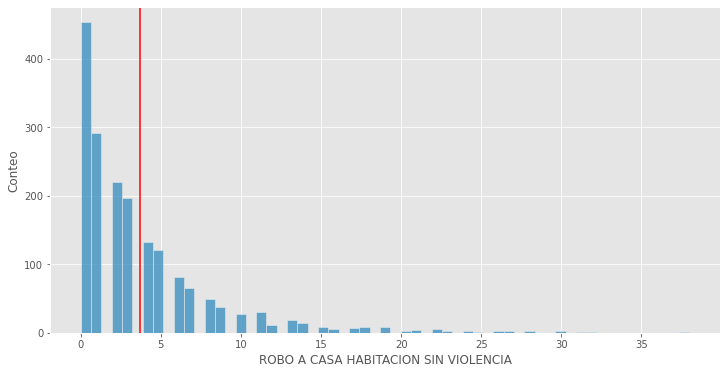

In [ ]:
ax = ca_19.displot_Y()

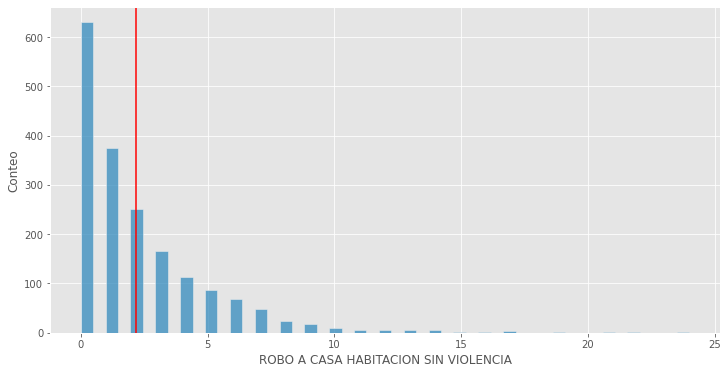

In [ ]:
ax = ca_21.displot_Y()

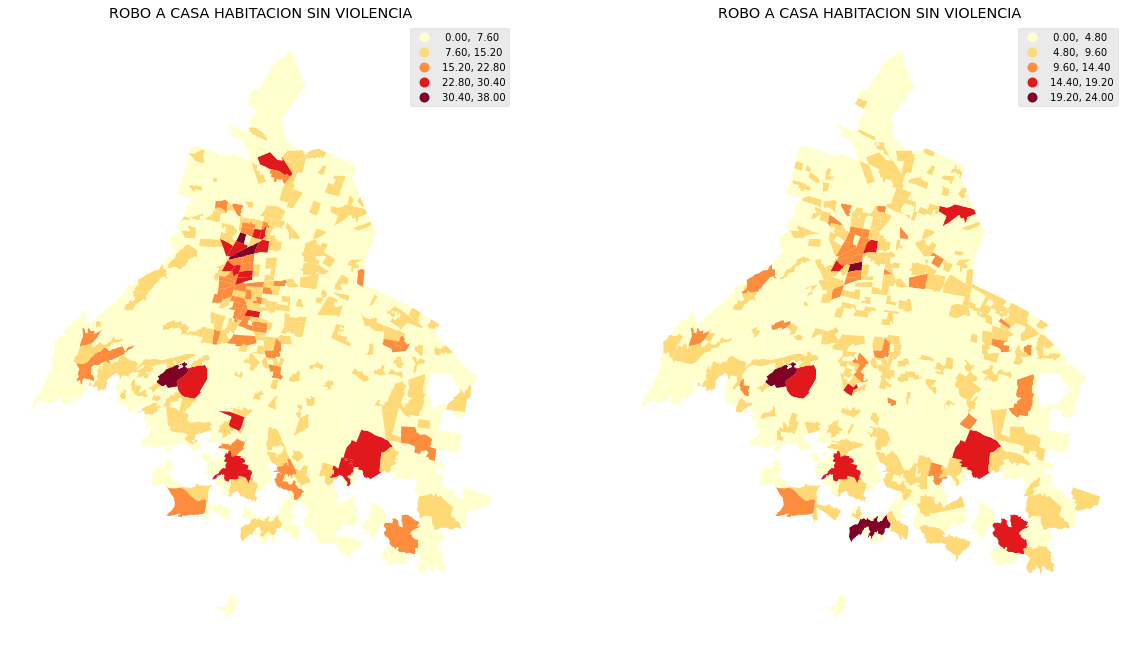

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
ax1 = ca_19.mapa_Y('colonias', clasificacion='equal_interval', ax=ax1)
ax2 = ca_21.mapa_Y('colonias', clasificacion='equal_interval', ax=ax2)

In [ ]:
m_19 = ModeloGLM(ca_19, sm.families.Poisson(), 'Nulo 2019')
r_19 = m_19.fit()
m_21 = ModeloGLM(ca_21, sm.families.Poisson(), 'Nulo 2021')
r_21 = m_21.fit()
comparacion_19_21 = ComparaModelos([m_19,m_21], ['coef', 'P>|z|'], 3)
comparacion_19_21.comparacion

Modelo Nulo 2019       Modelo Nulo 2021  \
                                              coef P>|z|             coef   
Q('VPH_3YMASC')                              0.627   0.0            0.539   
Q('Concentración de Desventajas')           -0.096   0.0           -0.005   
Q('VIVPAR_HAB')                              0.001   0.0            0.000   
Intercept                                   -0.252   0.0           -0.652   

                                          
                                   P>|z|  
Q('VPH_3YMASC')                    0.000  
Q('Concentración de Desventajas')  0.672  
Q('VIVPAR_HAB')                    0.000  
Intercept                          0.000

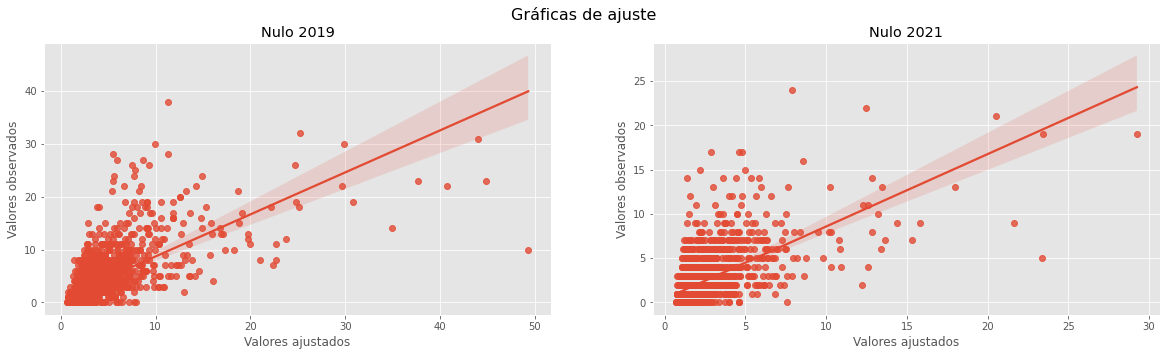

In [ ]:
comparacion_19_21.graficas_de_ajuste()

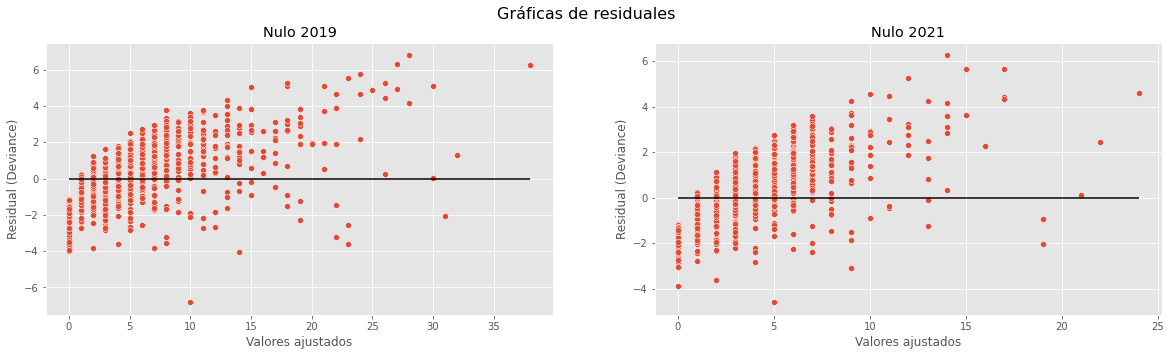

In [ ]:
comparacion_19_21.graficas_residuales()

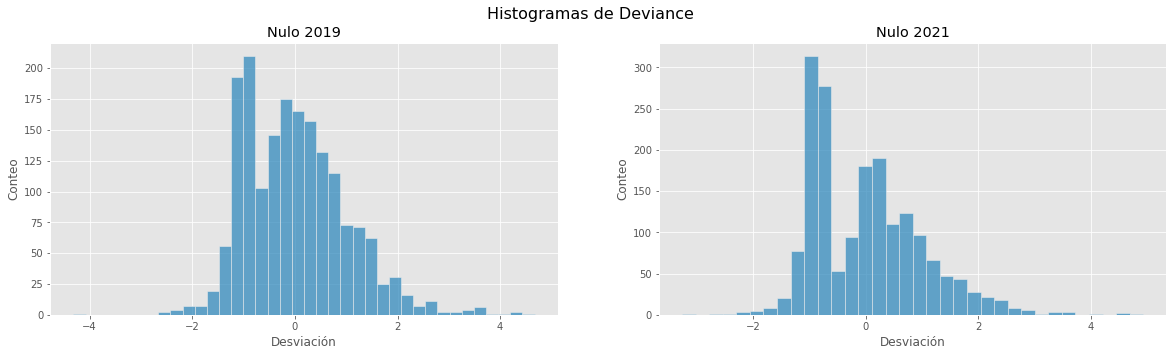

In [ ]:
comparacion_19_21.histogramas_deviance()

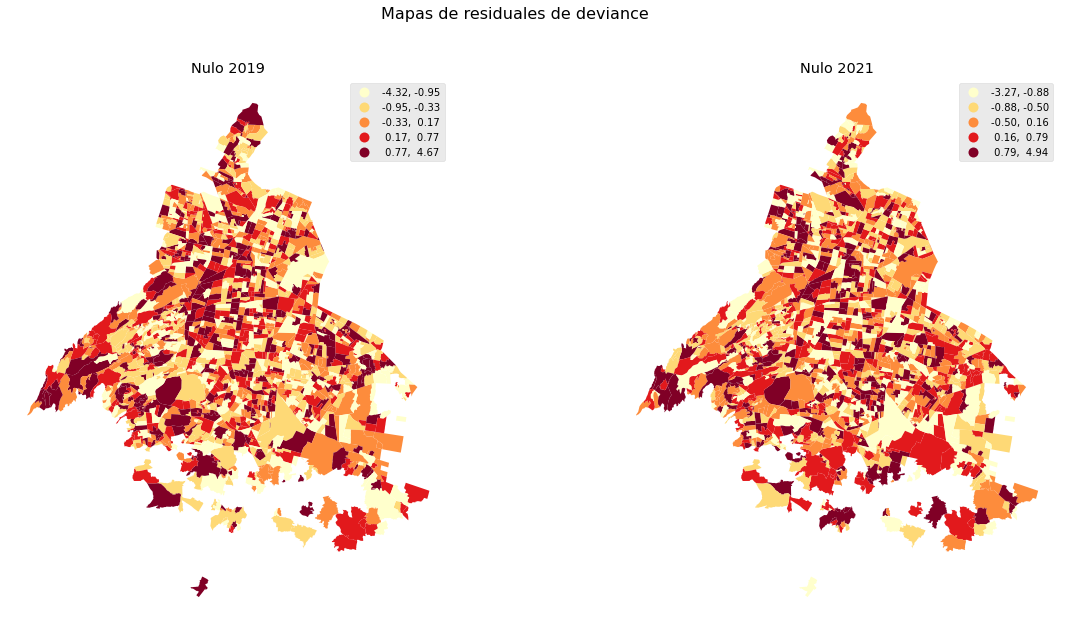

In [ ]:
comparacion_19_21.mapas_residuales()

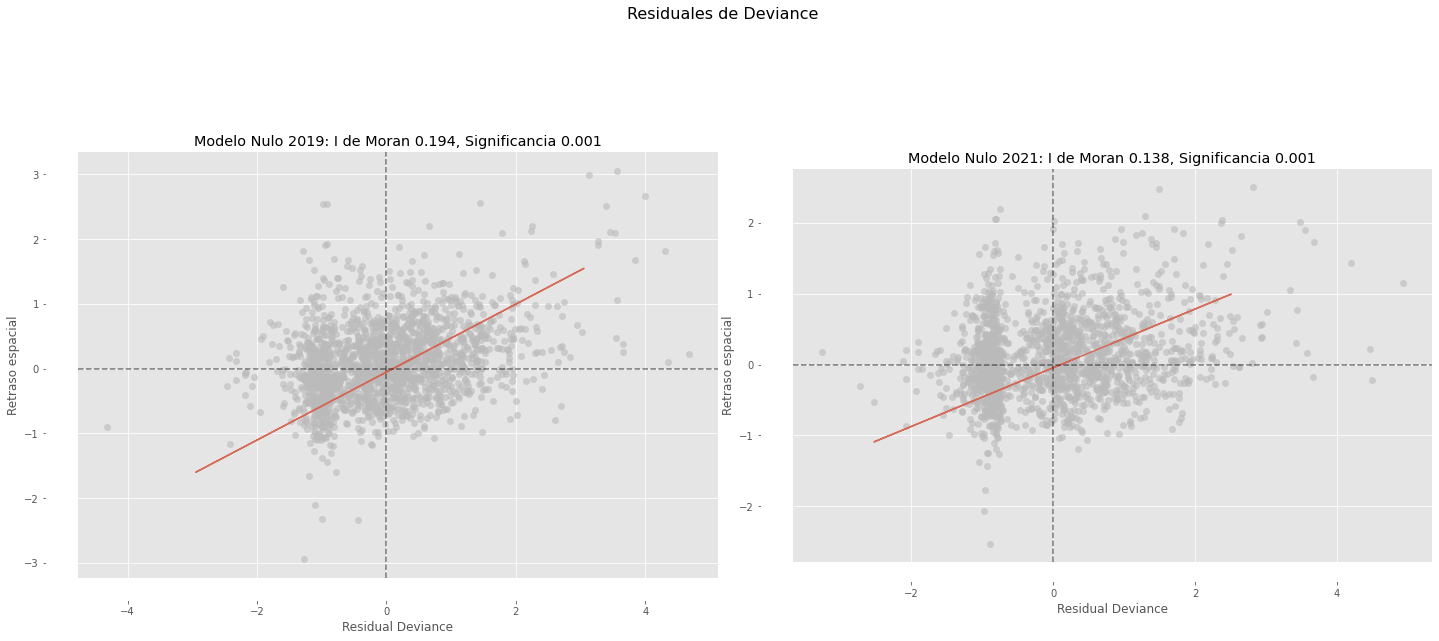

In [ ]:
comparacion_19_21.scatterpĺots_moran()

In [ ]:
m_19.df_resultado

,coef,std err,z,P>|z|,conf_lower,conf_higher
Intercept,-0.251626,0.066707,-3.772124,1.618638e-04,-0.382369,-0.120883
Q('VIVPAR_HAB'),0.000520,0.000007,71.522105,0.000000e+00,0.000506,0.000534
Q('VPH_3YMASC'),0.627411,0.069668,9.005784,2.141295e-19,0.490865,0.763957
Q('Concentración de Desventajas'),-0.095890,0.009276,-10.337299,4.778168e-25,-0.114071,-0.077709
